#### Imports and helper functions

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from scipy.stats import norm, probplot 

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output

def find_missing_values(df):
    df_nas = df.isnull().sum()
    df_nas = df_nas[df_nas>0]
    df_nas = df_nas.sort_values(ascending=False)
    return df_nas
    
    
def handle_missing_data(df):
    """This function handles all types of missing data form the dataframe."""
    
    # We will replace the NA values in this feature as None which mean no Pool
    df["PoolQC"] = df["PoolQC"].fillna("None")
    # MiscFeature : data description says NA means "no misc feature"
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    # Alley : data description says NA means "no alley access"
    df["Alley"] = df["Alley"].fillna("None")
    # Fence : data description says NA means "no fence"
    df["Fence"] = df["Fence"].fillna("None")
    # FireplaceQu : data description says NA means "no fireplace"
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    # LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
    # Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    # GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    # GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    # BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
    # MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    # MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    # Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
    df = df.drop(['Utilities'], axis=1)
    # Functional : data description says NA means typical
    df["Functional"] = df["Functional"].fillna("Typ")
    # Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    # KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    # Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    # SaleType : Fill in again with most frequent which is "WD"
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    # MSSubClass : Na most likely means No building class. We can replace missing values with None
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    return df
    


### Data Collection

In [7]:
print(check_output(["ls", "../input/house-prices-advanced-regression-techniques"]).decode("utf8")) #check the files available in the directory

data_description.txt
sample_submission.csv
test.csv
train.csv



##### Read Data from flatfiles to dataframe

In [8]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

##### Take a look at the Training and Test Data

In [9]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [11]:
train.shape,test.shape

((1460, 81), (1459, 80))

In [12]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


### Data Processing

**Outliers**

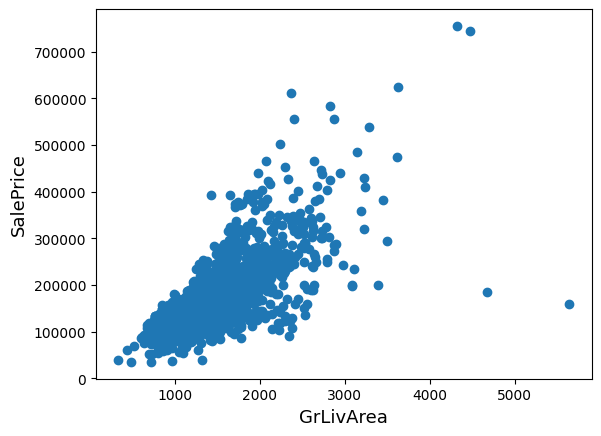

In [13]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

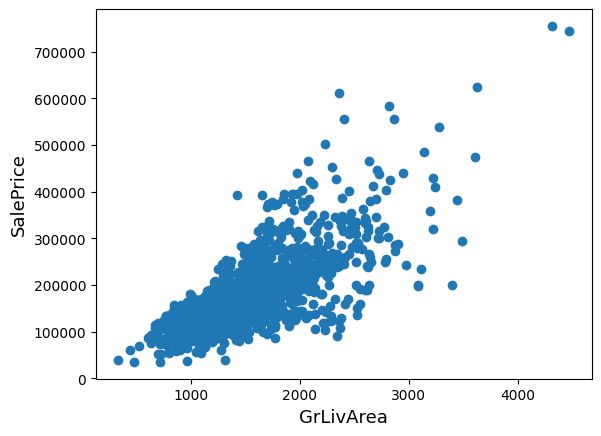

In [14]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Note :
Outliers removal is note always safe. We decided to delete these two as they are very huge and really bad ( extremely large areas for very low prices).

There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. You can refer to the modelling part of this notebook for that.

#### Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79



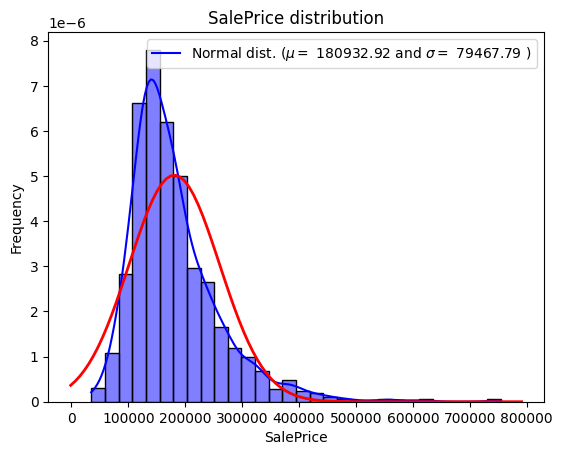

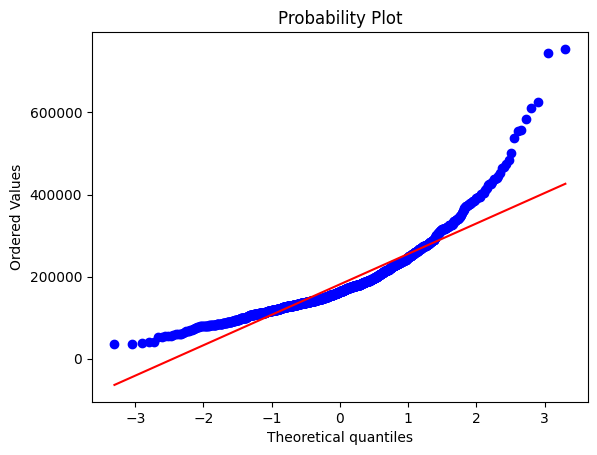

In [15]:
# Plot the distribution using sns.histplot and add a KDE (kernel density estimate) curve
sns.histplot(train['SalePrice'], kde=True, stat="density", bins=30, color='blue')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the fitted normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

# Add title, labels, and legend
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Show the QQ-plot to check the normality visually
fig = plt.figure()
res = probplot(train['SalePrice'], plot=plt)  # Use probplot directly from scipy.stats
plt.show()


 mu = 12.02 and sigma = 0.40



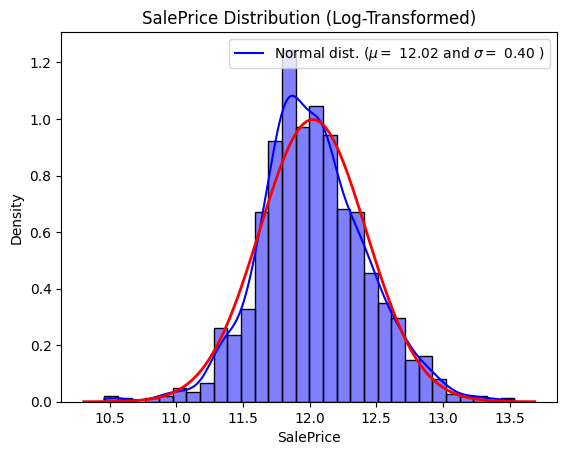

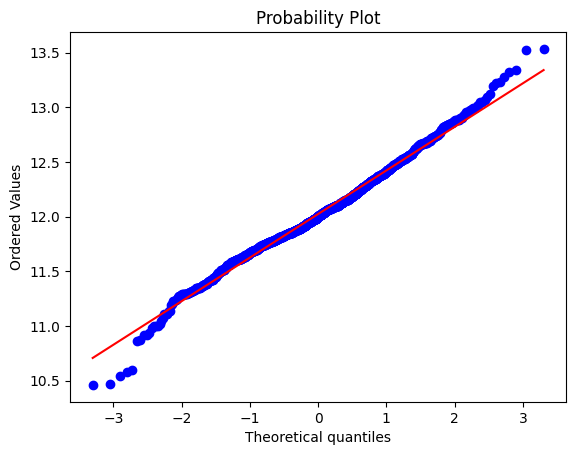

In [16]:
# Apply the log(1+x) transformation to the SalePrice column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution using sns.histplot
sns.histplot(train['SalePrice'], kde=True, stat="density", bins=30, color='blue')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the fitted normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

# Add title, labels, and legend
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Density')
plt.title('SalePrice Distribution (Log-Transformed)')

# Show the QQ-plot to check the normality visually
fig = plt.figure()
res = probplot(train['SalePrice'], plot=plt)  # Use probplot directly from scipy.stats
plt.show()

### Feature Engineering

Merge both training and test dataset

In [17]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


##### Check for null Values

In [18]:
all_data_nas = all_data.isnull().sum()
all_data_nas = all_data_nas[all_data_nas>0]
all_data_nas = all_data_nas.sort_values(ascending=False)
all_data_nas

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64

In [19]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation="vertical")
sns.barplot(x=all_data_nas.index, y=(all_data_nas/all_data_nas.shape[0]))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data by feature', fontsize=15)

Text(0.5, 1.0, 'Percentage of missing data by feature')

We impute them by proceeding sequentially through features with missing values

### Lets try to understand each feature and best path to handle missing values in them. 

**PoolQC**: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
       
**MiscFeature**: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
       

**PoolQC** : data description says NA means *"No Pool"*. That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [20]:
# We will replace the NA values in this feature as None which mean no Pool
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

**MiscFeature** : data description says NA means "no misc feature"

In [21]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

**LotFrontage**: Linear feet of street connected to property

[LotFrontage](https://upload.wikimedia.org/wikipedia/commons/b/bc/Lot_map.PNG)

In [22]:
all_data.groupby('Neighborhood')['LotFrontage'].apply(set)

Neighborhood
Blmngtn    {nan, nan, nan, nan, 43.0, nan, 51.0, 53.0, na...
Blueste                                         {24.0, 35.0}
BrDale                                          {24.0, 21.0}
BrkSide    {nan, nan, 144.0, nan, nan, 50.0, 51.0, 52.0, ...
ClearCr    {138.0, nan, 155.0, nan, nan, nan, 62.0, 65.0,...
CollgCr    {36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43....
Crawfor    {nan, 130.0, nan, nan, nan, nan, nan, nan, nan...
Edwards    {128.0, nan, 134.0, nan, nan, nan, 24.0, nan, ...
Gilbert    {41.0, 42.0, 50.0, 51.0, 53.0, 54.0, 56.0, 57....
IDOTRR     {nan, nan, nan, 40.0, 46.0, nan, nan, 50.0, 52...
MeadowV    {36.0, 41.0, 42.0, nan, 44.0, nan, 21.0, nan, ...
Mitchel    {129.0, nan, nan, nan, nan, 140.0, nan, nan, n...
NAmes      {nan, nan, nan, nan, nan, 26.0, nan, nan, nan,...
NPkVill                               {24.0, nan, 53.0, nan}
NWAmes     {128.0, nan, 130.0, nan, nan, nan, nan, nan, n...
NoRidge    {136.0, nan, nan, nan, 160.0, nan, nan, 174.0,...
NridgHt    

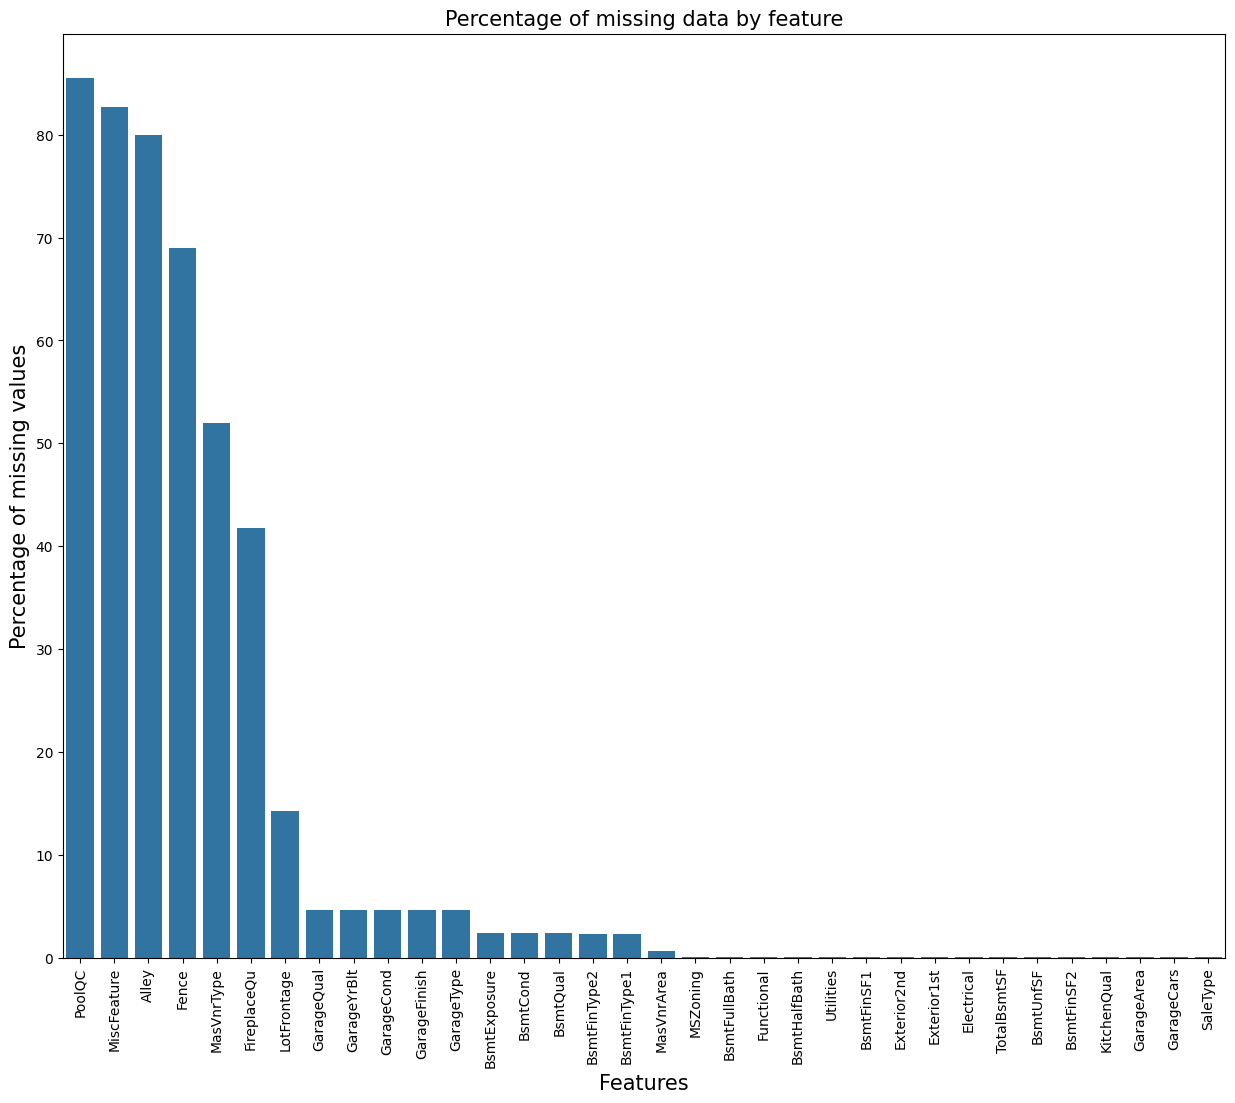

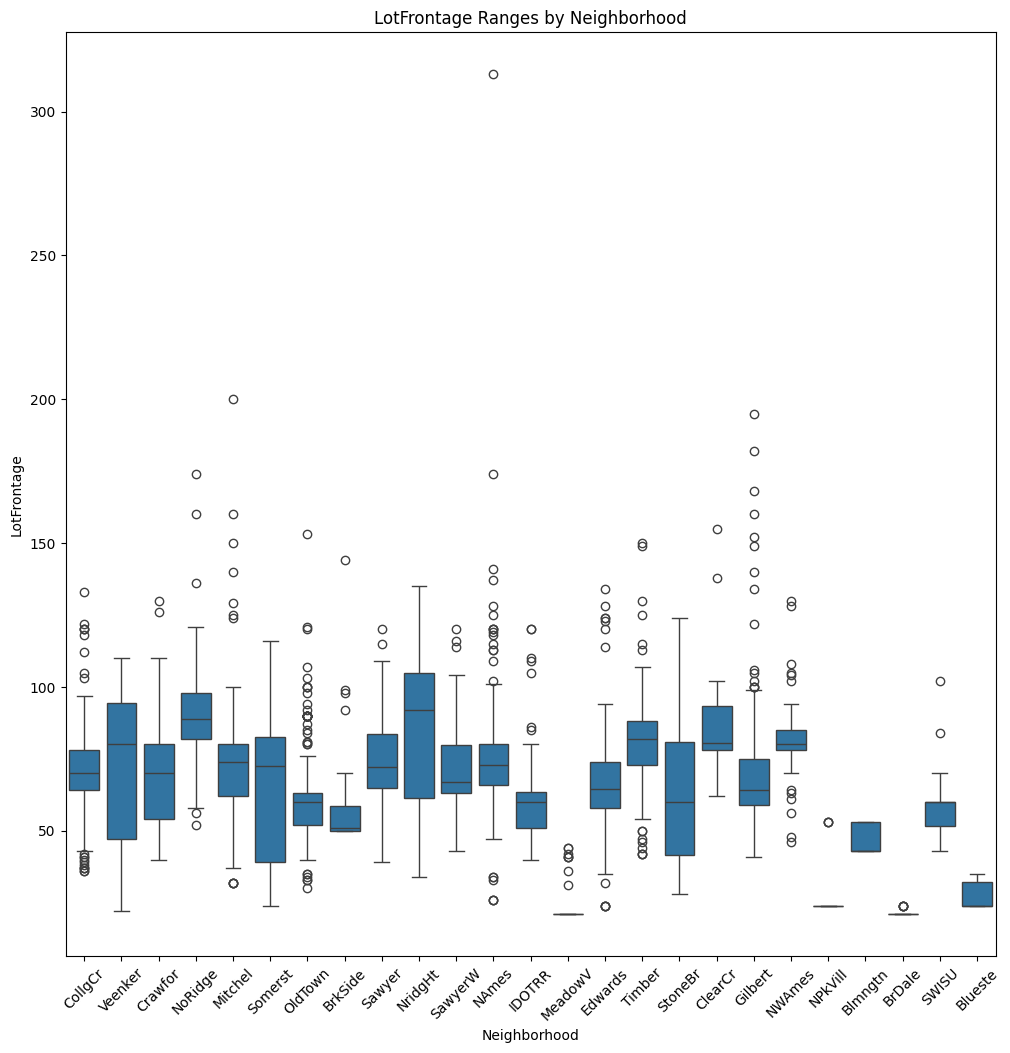

In [23]:
# Drop rows with null values in 'ValueColumn'
df = all_data.dropna(subset=['LotFrontage'])

# Set the plot size
plt.figure(figsize=(12, 12))

# Create a boxplot to show the range of LotFrontage by Neighborhood
sns.boxplot(x='Neighborhood', y='LotFrontage', data=df)

# Set the title and labels
plt.title('LotFrontage Ranges by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('LotFrontage')

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels if there are many neighborhoods
plt.show()

In [24]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

**Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [25]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

**KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [26]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [27]:
imputed_df = handle_missing_data(all_data)

In [28]:
find_missing_values(imputed_df)

Series([], dtype: int64)

In [29]:
all_data = imputed_df

### More Feature Engineering

**Transforming some numerical variables that are really categorical**

In [30]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Adding one more important feature**

In [31]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**One hot encoding**

In [32]:
all_data = pd.get_dummies(all_data)

Split the train and test set 

In [33]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### Modelling

**Import Libraries**

In [35]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Base Models

**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [36]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

**LASSO Regression** :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [37]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

**Elastic Net Regression** : Again made robust to outliers

In [38]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

**Kernel Ridge Regression** :

In [39]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

**Gradient Boosting Regression** : With huber loss that makes it robust to outliers

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

**XGBoost** :

In [41]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

**LightGBM**

In [42]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

**Base Model Scores**

In [43]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1120 (0.0059)



In [44]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1120 (0.0061)



In [45]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.5451 (0.1315)



In [46]:
# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [47]:
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### Predictions 

In [48]:
lasso.fit(train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.0005, random_state=1))])

In [49]:
test.shape

(1459, 338)

In [50]:
results = lasso.predict(test)

In [51]:
results = [np.expm1(x) for x in results ]

In [52]:
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [53]:
test_df["SalePrice"] = results

In [54]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,120433.917
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,152381.233
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,178483.518
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,201818.691
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,192558.162


In [55]:
test_df = test_df[['Id', 'SalePrice']]

In [56]:
test_df.to_csv("submission.csv", index=False)

**Save the model to be used later**

In [57]:
import joblib

In [58]:
joblib.dump(lasso, 'lasso_model.pkl')

['lasso_model.pkl']